<a href="https://colab.research.google.com/github/hayden-huynh/Facial-Expression-Image-Classifier/blob/master/Facial_Expression_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Load the facial expression dataset from Kaggle
# Reference: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download samaneheslamifar/facial-emotion-expressions
! unzip facial-emotion-expressions.zip

In [10]:
# Label the dataset images into csv files

import os
import csv

label_map = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}

train_csv = open("train_labels.csv", "w")
train_writer = csv.writer(train_csv)
test_csv = open("test_labels.csv", "w")
test_writer = csv.writer(test_csv)

train_root = "/content/images/train"
for label in sorted(os.listdir(train_root)):
  for img in sorted(os.listdir(os.path.join(train_root, label))):
    train_writer.writerow([os.path.join(label, img), label_map[label]])

test_root = "/content/images/validation"
for label in sorted(os.listdir(test_root)):
  for img in sorted(os.listdir(os.path.join(test_root, label))):
    test_writer.writerow([os.path.join(label, img), label_map[label]])


Feature batch shape: torch.Size([4, 1, 48, 48])
Labels batch shape: torch.Size([4])


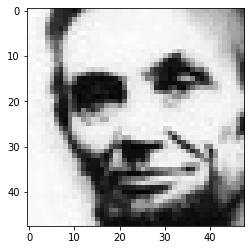

Label: happy


In [21]:
# Create training and testing datasets
# Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#iterating-and-visualizing-the-dataset

import os
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import matplotlib.pyplot as plt

classes = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

class FacialExpDataset(Dataset):
  def __init__(self, labels_csv, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(labels_csv)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label


train_data = FacialExpDataset("/content/train_labels.csv", train_root)
test_data = FacialExpDataset("/content/test_labels.csv", test_root)

batch_size = 4
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {classes[int(label)]}")
